In [22]:
import sys

sys.path.append("../")

In [23]:
import requests
import time
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
from ta.volatility import BollingerBands

import matplotlib.pyplot as plt


In [24]:
API_BASE = 'https://fapi.binance.com/fapi/v1/'
TIMEFRAME = '1h'
lookback = 60

# TIMEFRAME = '5m'
# lookback = 15

In [25]:


LABELS = [
    'open_time',
    'open',
    'high',
    'low',
    'close',
    'volume',
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]

DROP_COLUMNS=[
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]


def get_batch(symbol, interval='1m', start_time=0, limit=1000):
    """Use a GET request to retrieve a batch of candlesticks. Process the JSON into a pandas
    dataframe and return it. If not successful, return an empty dataframe.
    """

    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'limit': limit
    }
    try:
        # timeout should also be given as a parameter to the function
        response = requests.get(f'{API_BASE}klines', params, timeout=30)
    except requests.exceptions.ConnectionError:
        print('Connection error, Cooling down for 5 mins...')
        time.sleep(5 * 60)
        return get_batch(symbol, interval, start_time, limit)

    except requests.exceptions.Timeout:
        print('Timeout, Cooling down for 5 min...')
        time.sleep(5 * 60)
        return get_batch(symbol, interval, start_time, limit)

    if response.status_code == 200:
        return pd.DataFrame(response.json(), columns=LABELS)
    
    print(f'Got erroneous response back {symbol}: {response}. {response.text}')
    return pd.DataFrame([])


def get_candles(base, quote, start_date: datetime, interval='1m'):
    batches = []

    last_timestamp = int(start_date.timestamp()) * 1000
    # gather all candlesticks available, starting from the last timestamp loaded from disk or 0
    # stop if the timestamp that comes back from the api is the same as the last one
    previous_timestamp = None

    while previous_timestamp != last_timestamp:
        # stop if we reached data from today
        if datetime.fromtimestamp(last_timestamp / 1000) >= datetime.utcnow():
            break

        previous_timestamp = last_timestamp

        new_batch = get_batch(
            symbol=base + quote,
            interval=interval,
            start_time=last_timestamp
        )

        # requesting candles from the future returns empty
        # also stop in case response code was not 200
        if new_batch.empty:
            break

        last_timestamp = new_batch['open_time'].max()

        # sometimes no new trades took place yet on date.today();
        # in this case the batch is nothing new
        if previous_timestamp == last_timestamp:
            break

        batches.append(new_batch)
        last_datetime = datetime.fromtimestamp(last_timestamp / 1000)

        covering_spaces = 20 * ' '
        print(datetime.now(), base, quote, interval, str(last_datetime) + covering_spaces, end='\r', flush=True)

    if len(batches) > 0:
        # write clean version of csv to parquet
        df = pd.concat(batches, ignore_index=True)
        df.drop(columns=DROP_COLUMNS, inplace=True)
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        return df



In [26]:
# symbols = pd.read_csv(f'{DATA_PATH}/../symbols.csv')['symbol'].values.tolist()
symbols = ['BTCUSDT',
 'ETHUSDT',
 'BCHUSDT',
 'XRPUSDT',
 'EOSUSDT',
 'LTCUSDT',
 'TRXUSDT',
 'ETCUSDT',
 'LINKUSDT',
 'XLMUSDT',
 'ADAUSDT',
 'XMRUSDT',
 'DASHUSDT',
 'ZECUSDT',
 'XTZUSDT',
 'BNBUSDT',
 'ATOMUSDT',
 'ONTUSDT',
 'IOTAUSDT',
 'BATUSDT',
 'VETUSDT',
 'NEOUSDT',
 'QTUMUSDT',
 'IOSTUSDT',
 'THETAUSDT',
 'ALGOUSDT',
 'ZILUSDT',
 'KNCUSDT',
 'ZRXUSDT',
 'COMPUSDT',
 'OMGUSDT',
 'DOGEUSDT',
 'SXPUSDT',
 'KAVAUSDT',
 'BANDUSDT',
 'RLCUSDT',
 'WAVESUSDT',
 'MKRUSDT',
 'SNXUSDT',
 'DOTUSDT',
 'DEFIUSDT',
 'YFIUSDT',
 'BALUSDT',
 'CRVUSDT',
 'TRBUSDT',
 'RUNEUSDT',
 'SUSHIUSDT',
 'SRMUSDT',
 'EGLDUSDT',
 'SOLUSDT',
 'ICXUSDT',
 'STORJUSDT',
 'BLZUSDT',
 'UNIUSDT',
 'AVAXUSDT',
 'FTMUSDT',
 'HNTUSDT',
 'ENJUSDT',
 'FLMUSDT',
 'TOMOUSDT',
 'RENUSDT',
 'KSMUSDT',
 'NEARUSDT',
 'AAVEUSDT',
 'FILUSDT',
 'RSRUSDT',
 'LRCUSDT',
 'MATICUSDT',
 'OCEANUSDT',
 'CVCUSDT',
 'BELUSDT',
 'CTKUSDT',
 'AXSUSDT',
 'ALPHAUSDT',
 'ZENUSDT',
 'SKLUSDT',
 'GRTUSDT',
 '1INCHUSDT',
 'CHZUSDT',
 'SANDUSDT',
 'ANKRUSDT',
 'BTSUSDT',
 'LITUSDT',
 'UNFIUSDT',
 'REEFUSDT',
 'RVNUSDT',
 'SFPUSDT',
 'XEMUSDT',
 'BTCSTUSDT',
 'COTIUSDT',
 'CHRUSDT',
 'MANAUSDT',
 'ALICEUSDT',
 'HBARUSDT',
 'ONEUSDT',
 'LINAUSDT',
 'STMXUSDT',
 'DENTUSDT',
 'CELRUSDT',
 'HOTUSDT']
symbols = [s.replace('USDT', '') for s in symbols]

data = []

for symbol in symbols:
    df = get_candles(base=symbol, quote='USDT', start_date=datetime.now() - timedelta(days=lookback), interval=TIMEFRAME)
    if df is None:
        continue

    df.rename(columns={'close': symbol}, inplace=True)
    # the data is too long, just limit to recent period
    log = np.log(df[symbol].astype(np.float32))
    data.append(log)

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
# df.dropna(inplace=True, how='any')

df.head()

,BTC,ETH,BCH,XRP,EOS,LTC,TRX,ETC,LINK,XLM,...,CHR,MANA,ALICE,HBAR,ONE,LINA,STMX,DENT,CELR,HOT
0,10.285554,7.503406,5.188559,-0.927604,0.224742,4.155596,-2.493382,3.145746,1.895068,-2.086587,...,-1.560648,-0.023269,0.977198,-2.378603,-3.132240,-4.722828,-4.676666,-6.794426,-4.076898,-6.032703
1,10.267373,7.477417,5.170825,-0.947266,0.204572,4.131319,-2.519250,3.125839,1.864080,-2.101769,...,-1.604450,-0.050241,0.942738,-2.405061,-3.169847,-4.757156,-4.700581,-6.827097,-4.113527,-6.058032
2,10.269362,7.475095,5.163013,-0.946492,0.209450,4.134046,-2.517141,3.120204,1.868258,-2.100053,...,-1.610438,-0.055936,0.948177,-2.403400,-3.175338,-4.768867,-4.699481,-6.830794,-4.110474,-6.059743
3,10.265540,7.465020,5.163070,-0.952436,0.204572,4.126650,-2.525229,3.113071,1.851599,-2.108006,...,-1.630661,-0.062620,0.929404,-2.416202,-3.191018,-4.779524,-4.712755,-6.833576,-4.109255,-6.064466
4,10.253528,7.456940,5.149528,-0.962858,0.190620,4.120175,-2.533761,3.104587,1.838484,-2.122099,...,-1.638352,-0.083056,0.915891,-2.441502,-3.205466,-4.790296,-4.726209,-6.846660,-4.125835,-6.075716


In [27]:
# df.tail()

In [28]:
p = 1
COINTEGRATION_CONFIDENCE_LEVEL = 90

# the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
# eigenvalue statistic are stored in the first, second, and third column of 
# cvt and cvm, respectively
confidence_level_cols = {
    90: 0,
    95: 1,
    99: 2
}
confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]


def test_johansen(symbol_pairs):
    df_t = df[symbol_pairs].copy()
    df_t.dropna(inplace=True)

    # The second and third parameters indicate constant term, with a lag of 1. 
    result = coint_johansen(df_t, 0, p)

    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
#     print("trace_crit_value",trace_crit_value)
#     print("eigen_crit_value",eigen_crit_value)
#     print("lr1",result.lr1)
#     print("lr2",result.lr2)

    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # print(f"{symbol_pairs} are cointegrated")
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        coint_pair = dict(hedge_ratio=v1[:, 0])
        for i, s in enumerate(symbol_pairs):
            coint_pair[f'sid_{i+1}'] = s

        cointegrating_pairs.append(coint_pair)



In [29]:

import itertools as it

nb_symbols = 2
cointegrating_pairs = []

#get symbol pairs
pairs = list(it.combinations(symbols, nb_symbols))

for pair in pairs:
    try:
        test_johansen(list(pair))
    except Exception:
        pass

coint_df = pd.DataFrame(cointegrating_pairs)
coint_df.head()

,hedge_ratio,sid_1,sid_2
0,"[4.86586650782711, -13.459921700220788]",BTC,LTC
1,"[12.36621954354843, -18.713112909876568]",BTC,DASH
2,"[12.373044067646065, -20.04681484268066]",BTC,BNB
3,"[0.6175603901217613, 6.413490312080445]",BTC,ATOM
4,"[1.1918708436294603, 9.778793699235148]",BTC,BAT


In [30]:
coint_df.to_csv(f'coint_df_{TIMEFRAME}.csv')


In [31]:
def calculate_spread(df, selected_row, hedge_ratio):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
        else:
            spread += df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
    
    spread.dropna(inplace=True)
    return spread


critical_val = 0.005

def find_stationary_portfolio():
    data = []
    for i, _ in coint_df.iterrows():
        try:
            hedge_ratio = coint_df.iloc[i]['hedge_ratio']
            _df = df.copy()
            spread = calculate_spread(_df, i, hedge_ratio)
                
            half_life = cal_half_life(spread)
            pairs_name = coint_df[[col for col in coint_df.columns if col != 'hedge_ratio']].iloc[i].values
            # print(i, pairs_name, 'is stationary with half life', half_life)
            # print(' ')
            data.append({
                'i': i,
                'pairs': pairs_name,
                'half_life': half_life
            })
        except:
            pass
    
    return pd.DataFrame(data)


stationary_df = find_stationary_portfolio()
if len(stationary_df) > 0:
    stationary_df.sort_values(by=['half_life'], inplace=True)

/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [32]:
stationary_df.to_csv(f'stationary_df_{TIMEFRAME}.csv')
stationary_df

,i,pairs,half_life
71,71,"[XRP, ALPHA]",11
1149,1149,"[REEF, XEM]",12
670,670,"[BAND, LINA]",13
1166,1166,"[XEM, DENT]",13
303,303,"[ONT, CVC]",13
...,...,...,...
32,32,"[ETH, ATOM]",160
214,214,"[XMR, STORJ]",161
26,26,"[BTC, SAND]",165
16,16,"[BTC, UNI]",191


In [48]:
selected_row = stationary_df[stationary_df['i'] == 71]['i'].iloc[-1]
hedge_ratio = coint_df.iloc[selected_row]['hedge_ratio']
print(selected_row, hedge_ratio)
spread = calculate_spread(df, selected_row, hedge_ratio)
# spread = spread.iloc[-1000:]

71 [ 50.22671099 -33.26671499]


In [49]:
adf_test(spread, verbose=True)

Results of Dickey-Fuller Test:
Result: The series is  stationary


7.897546804420838e-08

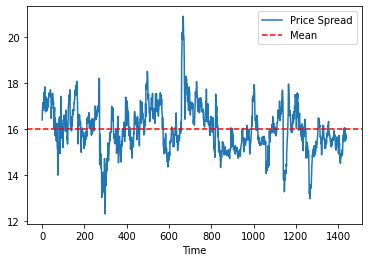

In [50]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [51]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

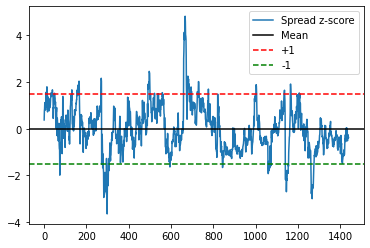

In [54]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.5, color='red', linestyle='--')
plt.axhline(-1.5, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])